# Kickstarter: Classification
Tests Include:
-KNN
-Logistic Regression
-Decision Trees
-Random Forest
-SVM
-Gradient Boosting

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

import sqlalchemy
from sqlalchemy import create_engine
from flask_sqlalchemy import SQLAlchemy

from sklearn import naive_bayes
from sklearn.naive_bayes import GaussianNB, BernoulliNB,MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve, auc
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import train_test_split, cross_val_predict
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import label_binarize, scale, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder

import datetime
import warnings
import os

warnings.filterwarnings("ignore") #, category=DeprecationWarning)

In [29]:
# env variable at tensorflow1.4 per https://conda.io/docs/user-guide/tasks/manage-environments.html#saving-environment-variables
# and https://vsupalov.com/flask-sqlalchemy-postgres/

def get_env_variable(name):
    try:
        return os.environ[name]
    except KeyError:
        message = "Expected environment variable '{}' not set.".format(name)
        raise Exception(message)

# the values of those depend on your setup
POSTGRES_URL = get_env_variable("POSTGRES_URL")
POSTGRES_USER = get_env_variable("POSTGRES_USER")
POSTGRES_PW = get_env_variable("POSTGRES_PW")
POSTGRES_DB = get_env_variable("POSTGRES_DB")

In [30]:
DB_URL = 'postgresql+psycopg2://{user}:{pw}@{url}/{db}'.format(user=POSTGRES_USER,pw=POSTGRES_PW,url=POSTGRES_URL,db=POSTGRES_DB)

In [31]:
engine_var = DB_URL
engine = create_engine(engine_var)

In [32]:
df = pd.read_pickle('data/kickstarter_data_ds2.pkl')
df['idx'] = df['id']
df = df.set_index('idx')
# df = pd.read_sql_query('''SELECT * FROM kickstarter_data_ds2''',engine)
df['state'] = df['state'].replace({'failed': 0, 'successful': 1})
df['spotlight'] = df['spotlight'].replace({False: 0, True: 1})
print(df.shape)
# pd.read_sql_query('''SELECT state, main_category, main_category, currency, currency, deadline, launched, usd_goal_real, usd_pledged_real FROM kickstarter_data_ds2 LIMIT 5''',engine)
df.head()

(163425, 19)


,id,name,state,category_main,category_name,backers_count,pct_goal_achieved,usd_pledged,usd_goal,country,currency,campaign_length,deadline,launched,created,staff_pick,spotlight,creator_name,blurb_length
idx,,,,,,,,,,,,,,,,,,,
1396766240,1396766240,Ripple Playing Cards - Printed by USPCC,0,games,Playing Cards,131,0.3,3387.000000,9999.000000,US,USD,38,2018-01-12,2017-12-05,2017-10-08,0,0,B.Y. Eidelman,16
2065169465,2065169465,Cotton-Top Pastries,1,food,Small Batch,99,1.3,9858.000000,7500.000000,US,USD,30,2018-01-12,2017-12-13,2017-12-12,1,1,Holly Weist,5
1647325451,1647325451,Code Switch,1,film_and_video,Horror,34,1.5,4611.000000,3000.000000,US,USD,32,2018-01-12,2017-12-11,2017-11-10,0,1,Alba Roland,23
727157486,727157486,Rain Dog Farm,0,food,Farms,49,0.3,4741.000000,18000.000000,US,USD,38,2018-01-12,2017-12-05,2017-11-28,1,0,Charlie Wainger,9
1756145145,1756145145,WANGTA: a novel,1,publishing,Fiction,13,1.0,427.185132,427.185132,CA,CAD,21,2018-01-12,2017-12-22,2017-12-18,0,1,D. H. de Bruin,22


In [33]:
df.corr().sort_values('state')

,id,state,backers_count,pct_goal_achieved,usd_pledged,usd_goal,campaign_length,staff_pick,spotlight,blurb_length
campaign_length,0.005133,-0.089709,0.005262,-0.005714,0.015575,0.024598,1.000000,-0.009770,-0.089709,0.037894
usd_goal,0.003757,-0.033841,0.014228,-0.000685,0.016147,1.000000,0.024598,-0.005367,-0.033841,-0.002520
id,1.000000,-0.003156,-0.001980,-0.001269,-0.000468,0.003757,0.005133,0.001558,-0.003156,0.000146
blurb_length,0.000146,0.001104,-0.013996,-0.002498,-0.012055,-0.002520,0.037894,-0.021259,0.001104,1.000000
pct_goal_achieved,-0.001269,0.015741,0.011325,1.000000,0.008084,-0.000685,-0.005714,0.001501,0.015741,-0.002498
usd_pledged,-0.000468,0.107837,0.810157,0.008084,1.000000,0.016147,0.015575,0.143184,0.107837,-0.012055
backers_count,-0.001980,0.116073,1.000000,0.011325,0.810157,0.014228,0.005262,0.152846,0.116073,-0.013996
staff_pick,0.001558,0.257915,0.152846,0.001501,0.143184,-0.005367,-0.009770,1.000000,0.257915,-0.021259
state,-0.003156,1.000000,0.116073,0.015741,0.107837,-0.033841,-0.089709,0.257915,1.000000,0.001104
spotlight,-0.003156,1.000000,0.116073,0.015741,0.107837,-0.033841,-0.089709,0.257915,1.000000,0.001104


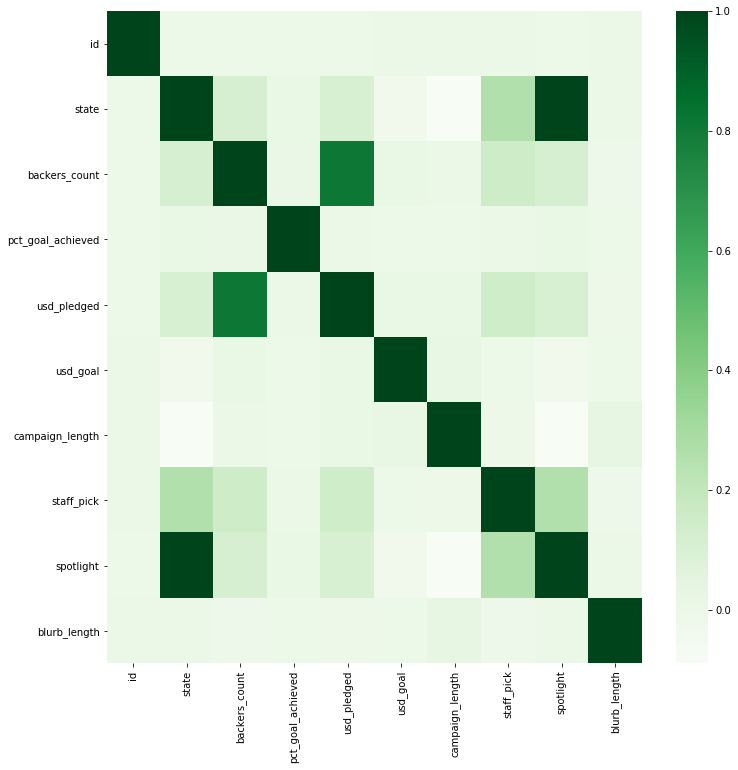

In [34]:
plt.figure(figsize = (12,12))
# sns.heatmap(df.corr(), cmap = 'coolwarm')
sns.heatmap(df.corr(), cmap = "Greens" )
# plot_corr_matrix(df)
# sns.heatmap(df.corr(),linecolor = "coolwarm")

In [35]:
start_date = datetime.datetime.strptime('2017-06-30', "%Y-%m-%d").date()

df = df[df['launched'] >= start_date] # filter from start date to current
df.shape

(8524, 19)

In [36]:
df_success = df[df['state'] == 1]
df_fail = df[df['state'] == 0]
print(df_success.shape)
df_success.head()

(4904, 19)


,id,name,state,category_main,category_name,backers_count,pct_goal_achieved,usd_pledged,usd_goal,country,currency,campaign_length,deadline,launched,created,staff_pick,spotlight,creator_name,blurb_length
idx,,,,,,,,,,,,,,,,,,,
2065169465,2065169465,Cotton-Top Pastries,1,food,Small Batch,99,1.3,9858.000000,7500.000000,US,USD,30,2018-01-12,2017-12-13,2017-12-12,1,1,Holly Weist,5
1647325451,1647325451,Code Switch,1,film_and_video,Horror,34,1.5,4611.000000,3000.000000,US,USD,32,2018-01-12,2017-12-11,2017-11-10,0,1,Alba Roland,23
1756145145,1756145145,WANGTA: a novel,1,publishing,Fiction,13,1.0,427.185132,427.185132,CA,CAD,21,2018-01-12,2017-12-22,2017-12-18,0,1,D. H. de Bruin,22
1339075969,1339075969,Run This Place - The Book,1,publishing,Nonfiction,483,1.0,20190.220000,20000.000000,US,USD,30,2018-01-12,2017-12-13,2017-12-12,0,1,Dane Rauschenberg,18
1928677105,1928677105,Casemates: a wine community site with direct v...,1,technology,Web,1829,2.4,120085.890000,50000.000000,US,USD,15,2018-01-12,2017-12-28,2017-12-18,1,1,Matt Rutledge,21


In [37]:
print(df_fail.shape)
df_fail.head()

(3620, 19)


,id,name,state,category_main,category_name,backers_count,pct_goal_achieved,usd_pledged,usd_goal,country,currency,campaign_length,deadline,launched,created,staff_pick,spotlight,creator_name,blurb_length
idx,,,,,,,,,,,,,,,,,,,
1396766240,1396766240,Ripple Playing Cards - Printed by USPCC,0,games,Playing Cards,131,0.3,3387.0,9999.0,US,USD,38,2018-01-12,2017-12-05,2017-10-08,0,0,B.Y. Eidelman,16
727157486,727157486,Rain Dog Farm,0,food,Farms,49,0.3,4741.0,18000.0,US,USD,38,2018-01-12,2017-12-05,2017-11-28,1,0,Charlie Wainger,9
739505843,739505843,Reusable Model Rocket Engines,0,technology,Flight,36,0.5,2401.7,5000.0,US,USD,45,2018-01-12,2017-11-28,2016-12-16,0,0,XAIR Aerospace Technologies LLC,20
1725323227,1725323227,Inspire young girls,0,fashion,Childrenswear,1,0.0,30.0,1300.0,US,USD,30,2018-01-12,2017-12-13,2017-12-08,0,0,Rayna,6
220865038,220865038,The New Way to Shop for Babies and Kids,0,fashion,Childrenswear,75,0.1,2734.0,20000.0,US,USD,46,2018-01-12,2017-11-27,2017-10-06,0,0,Little Starters,25


In [38]:
df.category_main.unique()

array(['games', 'food', 'film_and_video', 'publishing', 'technology',
       'fashion', 'art', 'comics', 'music', 'crafts', 'dance', 'design',
       'photography', 'theater', 'journalism'], dtype=object)

In [39]:
# sns.set_style('whitegrid')
# df['usd_pledged'].hist(bins=30)
# plt.xlabel('Pledged')

In [40]:
df_success.pct_goal_achieved.mean()
df_fail.pct_goal_achieved.mean()

0.11269102990033224

In [41]:
df.columns

Index(['id', 'name', 'state', 'category_main', 'category_name',
       'backers_count', 'pct_goal_achieved', 'usd_pledged', 'usd_goal',
       'country', 'currency', 'campaign_length', 'deadline', 'launched',
       'created', 'staff_pick', 'spotlight', 'creator_name', 'blurb_length'],
      dtype='object')

In [42]:
# df['category_name'].unique()
df.groupby('state').nunique()

,id,name,state,category_main,category_name,backers_count,pct_goal_achieved,usd_pledged,usd_goal,country,currency,campaign_length,deadline,launched,created,staff_pick,spotlight,creator_name,blurb_length
state,,,,,,,,,,,,,,,,,,,
0,3620,3620,1,15,113,174,11,1966,1319,22,14,61,182,178,458,2,1,3535,32
1,4904,4902,1,15,135,797,212,4563,2082,22,14,60,186,181,512,2,1,4651,31


In [43]:
df['country'].unique()

array(['US', 'CA', 'GB', 'AT', 'HK', 'FR', 'IT', 'NL', 'ES', 'AU', 'BE',
       'MX', 'DE', 'NZ', 'SG', 'SE', 'DK', 'NO', 'IE', 'CH', 'LU', 'JP'], dtype=object)

In [44]:
country_dict = {}
country_list = ['US', 'CA', 'GB', 'AT', 'HK', 'FR', 'IT', 'NL', 'ES', 'AU', 'BE',
       'MX', 'DE', 'NZ', 'SG', 'SE', 'DK', 'NO', 'IE', 'CH', 'LU', 'JP','All','Other']
for country in country_list:
    if country == 'All':
        df_c = df
    elif country == 'Other':
        df_c = df[~df.country.isin(country_list)]
    else:
        df_c = df[df['country'] == country]
    df_c = df_c.dropna()
    state_mean = df_c['state'].mean()
    backers_mean = df_c['backers_count'].mean()
    pledged_mean = df_c['usd_pledged'].mean()
    goal_mean = df_c['usd_goal'].mean()
    campaign_mean = df_c['campaign_length'].mean()
    staff_pick_mean = df_c['staff_pick'].mean()
    blurb_mean = df_c['blurb_length'].mean()

    state_total = df_c['state'].sum()
    backers_total = df_c['backers_count'].sum()
    pledged_total = df_c['usd_pledged'].sum()
    goal_total = df_c['usd_goal'].sum()
    pct_goal_achieved = pledged_total/goal_total
    
    country_dict[country] = {"state_mean":state_mean, "backers_mean": backers_mean, "pledged_mean":pledged_mean, 
                         "goal_mean":goal_mean, "campaign_mean":campaign_mean, "staff_pick_mean":staff_pick_mean, 
                         "blurb_mean":blurb_mean, "state_total": state_total, "backers_total":backers_total,
                            "pledged_total":pledged_total,"goal_total":goal_total,"pct_goal_achieved": pct_goal_achieved}

In [45]:
cd = pd.DataFrame(country_dict).T
cd = cd.sort_values(['pledged_total'],ascending=[False])
cd

,backers_mean,backers_total,blurb_mean,campaign_mean,goal_mean,goal_total,pct_goal_achieved,pledged_mean,pledged_total,staff_pick_mean,state_mean,state_total
All,144.765858,1145677.0,18.785823,31.448319,39138.831590,3.097447e+08,0.351758,13767.395239,1.089552e+08,0.141142,0.619661,4904.0
US,151.810335,775599.0,18.962419,31.362498,41915.369348,2.141456e+08,0.374491,15696.928272,8.019561e+07,0.133098,0.615972,3147.0
GB,119.602285,115177.0,18.761163,30.046729,20852.831863,2.008128e+07,0.373207,7782.423427,7.494474e+06,0.159917,0.698858,673.0
CA,159.189189,64790.0,18.503686,31.670762,44441.274073,1.808760e+07,0.230673,10251.409880,4.172324e+06,0.174447,0.697789,284.0
AU,196.064516,42546.0,18.612903,31.294931,24781.150594,5.377510e+06,0.614001,15215.649353,3.301796e+06,0.161290,0.635945,138.0
HK,261.455882,17779.0,18.132353,33.000000,24130.676667,1.640886e+06,1.382260,33354.867211,2.268131e+06,0.102941,0.720588,49.0
DE,118.468927,20969.0,17.853107,30.186441,12836.371943,2.272038e+06,0.866158,11118.332370,1.967945e+06,0.152542,0.519774,92.0
FR,140.251748,20056.0,18.580420,34.370629,11833.731710,1.692224e+06,1.007906,11927.283519,1.705602e+06,0.160839,0.622378,89.0
SE,255.376812,17621.0,18.260870,31.289855,182047.473052,1.256128e+07,0.094421,17189.042345,1.186044e+06,0.144928,0.623188,43.0
CH,134.487179,5245.0,17.769231,32.871795,17677.138559,6.894084e+05,1.492952,26391.116907,1.029254e+06,0.102564,0.512821,20.0


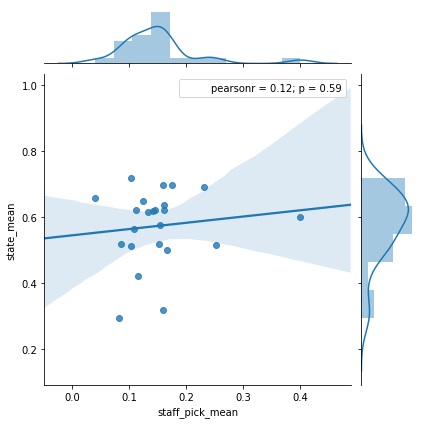

In [46]:
sns.jointplot(x='staff_pick_mean',y='state_mean', kind='reg',data=cd)

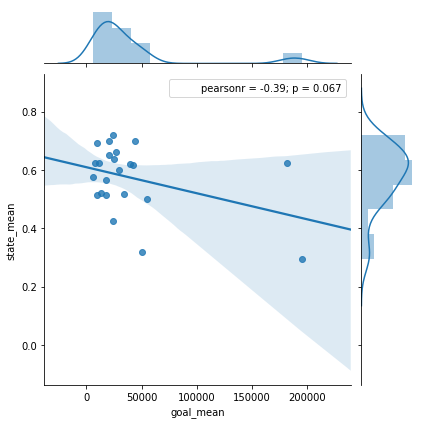

In [47]:
sns.jointplot(x='goal_mean',y='state_mean', kind='reg',data=cd)

In [20]:
df['category_name'].unique()

array(['Playing Cards', 'Small Batch', 'Horror', 'Farms', 'Fiction',
       'Nonfiction', 'Flight', 'Childrenswear', 'Ready-to-wear',
       'Television', 'Web', 'Performance Art', 'Drinks', 'Graphic Novels',
       'Music Videos', 'Hip-Hop', 'Stationery', 'Mixed Media',
       'Food Trucks', 'Comedy', 'Restaurants', 'Electronic Music',
       'Literary Spaces', 'Mobile Games', 'Cookbooks', 'Zines', 'Jazz',
       'Periodicals', 'Jewelry', 'Radio & Podcasts', 'Apps',
       "Children's Books", 'Accessories', 'DIY', 'Candles', 'Apparel',
       'Dance', '3D Printing', 'Illustration', 'Video Art',
       'Graphic Design', 'Anthologies', 'Footwear', 'Photobooks',
       'Fine Art', 'Plays', 'Translations', 'Sound', 'Latin',
       'Architecture', 'Animation', 'Spaces', 'Webseries', 'Nature',
       'Couture', 'Performances', 'Workshops', 'Movie Theaters', 'Audio',
       'World Music', 'Hardware', 'Experimental', 'Gaming Hardware',
       'Narrative Film', 'Crafts', 'Drama', 'Blues', 'Fab

In [21]:
subcat_dict = {}
subcat_list = ['Playing Cards', 'Small Batch', 'Horror', 'Farms', 'Fiction',
       'Nonfiction', 'Flight', 'Childrenswear', 'Ready-to-wear',
       'Television', 'Web', 'Performance Art', 'Drinks', 'Graphic Novels',
       'Music Videos', 'Hip-Hop', 'Stationery', 'Mixed Media',
       'Food Trucks', 'Comedy', 'Restaurants', 'Electronic Music',
       'Literary Spaces', 'Mobile Games', 'Cookbooks', 'Zines', 'Jazz',
       'Periodicals', 'Jewelry', 'Radio & Podcasts', 'Apps',
       "Children's Books", 'Accessories', 'DIY', 'Candles', 'Apparel',
       'Dance', '3D Printing', 'Illustration', 'Video Art',
       'Graphic Design', 'Anthologies', 'Footwear', 'Photobooks',
       'Fine Art', 'Plays', 'Translations', 'Sound', 'Latin',
       'Architecture', 'Animation', 'Spaces', 'Webseries', 'Nature',
       'Couture', 'Performances', 'Workshops', 'Movie Theaters', 'Audio',
       'World Music', 'Hardware', 'Experimental', 'Gaming Hardware',
       'Narrative Film', 'Crafts', 'Drama', 'Blues', 'Fabrication Tools',
       'Pop', 'Art Books', 'DIY Electronics', 'Pottery', 'Animals',
       'Ceramics', 'Academic', 'Gadgets', 'Wearables', 'Festivals',
       'Public Art', 'Vegan', 'Faith', 'Metal', 'Webcomics', 'Video',
       'Sculpture', 'Romance', 'Interactive Design', 'Fantasy',
       'Classical Music', 'Civic Design', 'Family', 'Live Games',
       'Calendars', 'Comic Books', 'Robots', 'Events', 'Thrillers',
       'Science Fiction', 'Textiles', 'Software', 'Poetry',
       'Installations', 'Camera Equipment', 'Painting', 'People',
       'Space Exploration', 'Print', 'Musical', 'Typography', 'Action',
       'Journalism', 'Immersive', 'R&B', 'Pet Fashion', 'Conceptual Art',
       'Woodworking', 'Young Adult', 'Weaving', 'Photo', 'Letterpress',
       'Puzzles', 'Punk', 'Places', 'Embroidery', "Farmer's Markets",
       'Literary Journals', 'Printing', 'Makerspaces', 'Knitting', 'Kids',
       'Video Games', 'Glass', 'Community Gardens', 'Bacon', 'Crochet',
       'Quilts', 'Residencies'] #'All','Other']
for subcat in subcat_list:
    if subcat == 'All':
        df_c = df
    elif subcat == 'Other':
        df_c = df[~df.category_name.isin(subcat_list)]
    else:
        df_c = df[df['category_name'] == subcat]
    df_c = df_c.dropna()
    main_cat = df_c['category_main'].unique()[0]
    cat_count = df_c['id'].count()
    state_mean = df_c['state'].mean()
    backers_mean = df_c['backers_count'].mean()
    pledged_mean = df_c['usd_pledged'].mean()
    goal_mean = df_c['usd_goal'].mean()
    campaign_mean = df_c['campaign_length'].mean()
    staff_pick_mean = df_c['staff_pick'].mean()
    blurb_mean = df_c['blurb_length'].mean()

    state_total = df_c['state'].sum()
    backers_total = df_c['backers_count'].sum()
    pledged_total = df_c['usd_pledged'].sum()
    goal_total = df_c['usd_goal'].sum()
    pct_goal_achieved = pledged_total/goal_total
    
    subcat_dict[subcat] = {"state_mean":state_mean, "backers_mean": backers_mean, "pledged_mean":pledged_mean, 
                         "goal_mean":goal_mean, "campaign_mean":campaign_mean, "staff_pick_mean":staff_pick_mean, 
                         "blurb_mean":blurb_mean, "state_total": state_total, "backers_total":backers_total,
                            "pledged_total":pledged_total,"goal_total":goal_total,"pct_goal_achieved": pct_goal_achieved}
#     "main_cat":main_cat,"cat_count":cat_count,

In [22]:
scd = pd.DataFrame(subcat_dict).T
scd = pd.DataFrame(scd)
scd['cat_name'] = scd.index
scd = scd.sort_values(['pledged_total'],ascending=[False])
scd

,backers_mean,backers_total,blurb_mean,campaign_mean,goal_mean,goal_total,pct_goal_achieved,pledged_mean,pledged_total,staff_pick_mean,state_mean,state_total,cat_name
Hardware,600.168831,46213.0,18.051948,35.649351,3.332986e+04,2.566399e+06,4.429690,147640.943567,1.136835e+07,0.350649,1.000000,77.0,Hardware
Wearables,617.750000,61775.0,18.910000,34.700000,5.612481e+04,5.612481e+06,1.606138,90144.166343,9.014417e+06,0.080000,0.480000,48.0,Wearables
Gadgets,335.869369,74563.0,18.157658,34.914414,2.959143e+04,6.569298e+06,1.231471,36440.987434,8.089899e+06,0.063063,0.554054,123.0,Gadgets
Video Games,910.420168,108340.0,18.252101,30.504202,1.978138e+04,2.353984e+06,1.967618,38922.197501,4.631742e+06,0.512605,1.000000,119.0,Video Games
Sound,325.662162,24099.0,18.337838,34.081081,4.336393e+04,3.208931e+06,1.128478,48935.230604,3.621207e+06,0.270270,0.567568,42.0,Sound
Apparel,177.901734,30777.0,17.982659,30.653179,8.822570e+03,1.526305e+06,2.150279,18970.986035,3.281981e+06,0.121387,1.000000,173.0,Apparel
Camera Equipment,392.000000,15680.0,18.250000,33.825000,3.168163e+04,1.267265e+06,2.463714,78054.481847,3.122179e+06,0.150000,0.450000,18.0,Camera Equipment
3D Printing,196.934783,9059.0,17.956522,33.326087,3.800799e+04,1.748368e+06,1.698447,64554.566728,2.969510e+06,0.065217,0.391304,18.0,3D Printing
Accessories,96.788079,29230.0,16.778146,28.331126,3.414421e+03,1.031155e+06,2.863925,9778.644759,2.953151e+06,0.066225,1.000000,302.0,Accessories
Fabrication Tools,724.588235,12318.0,19.176471,31.352941,4.498531e+04,7.647503e+05,3.695805,166256.928921,2.826368e+06,0.235294,0.705882,12.0,Fabrication Tools


In [23]:
# scd = scd[['cat_name','main_cat','staff_pick_mean','state_mean']]
# scd.to_csv('data/kickstarter_bostockscatterplot.csv',index=False)

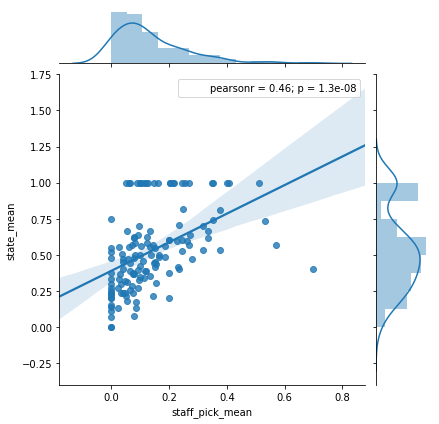

In [27]:
# color = ['b', 'r']
# scd = scd.drop(['main_cat'],1)
sns.jointplot(x='staff_pick_mean',y='state_mean',kind='reg',data=scd)

In [ ]:
# scd = scd[['cat_name','main_cat','staff_pick_mean','state_mean']]


In [ ]:
state_dict = {}
state_list = [('Fail',0),('Success',1),('All','All')]

for state in state_list:
    if state[0] == 'All':
        df_c = df
    else:
        df_c = df[df['state'] == state[1]]
    df_c = df_c.dropna()
    state_mean = df_c['state'].mean()
    backers_mean = df_c['backers_count'].mean()
    pledged_mean = df_c['usd_pledged'].mean()
    goal_mean = df_c['usd_goal'].mean()
    campaign_mean = df_c['campaign_length'].mean()
    staff_pick_mean = df_c['staff_pick'].mean()
    blurb_mean = df_c['blurb_length'].mean()
    
    state_total = df_c['state'].sum()
    backers_total = df_c['backers_count'].sum()
    pledged_total = df_c['usd_pledged'].sum()
    goal_total = df_c['usd_goal'].sum()
    pct_goal_achieved = pledged_total/goal_total
    
    state_dict[state[0]] = {"state_mean":state_mean, "backers_mean": backers_mean, "pledged_mean":pledged_mean, 
                         "goal_mean":goal_mean, "campaign_mean":campaign_mean, "staff_pick_mean":staff_pick_mean, 
                         "blurb_mean":blurb_mean, "state_total": state_total, "backers_total":backers_total,
                            "pledged_total":pledged_total,"goal_total":goal_total,"pct_goal_achieved": pct_goal_achieved}

In [ ]:
sd = pd.DataFrame(state_dict).T
sd

In [ ]:
sns.jointplot(x='backers_mean',y='goal_mean', data=sd)

In [ ]:
# ax = sns.swarmplot(x="state", y="staff_pick", data=df)

In [ ]:
df['not_staff_pick'] = df['staff_pick'].replace({0:1,1:0})

fig,ax = plt.subplots(1,2,figsize=(12,5))
ax = plt.subplot(121)
ax = sns.barplot(x='state',y='staff_pick', data=df)

ax = plt.subplot(122)
ax = sns.barplot(x='state',y='not_staff_pick', data=df)

In [ ]:
# g = sns.factorplot(x="state", y="backers_count",hue="staff_pick", col="usd_pledged",data=df, kind="bar",size=4, aspect=.7);

In [ ]:
sns.jointplot(x='state',y='spotlight', data=df, kind='reg')

In [ ]:
sns.jointplot(x='usd_pledged',y='backers_count', data=df, kind='reg')

In [ ]:
sns.jointplot(x='usd_pledged',y='usd_goal', xlim=(0,1000000),ylim=(0,1000000),data=df)

In [ ]:
# sns.jointplot(x='usd_pledged',y='state',alpha=0.5,data=df)

sns.jointplot(x='usd_goal',y='state',alpha=0.3,data=df, kind='scatter')
# sns.jointplot(x='usd_goal',y='state',data=df, kind='reg')
# sns.jointplot(x='usd_goal',y='state',data=df, kind='resid')
# sns.jointplot(x='usd_goal',y='state',data=df, kind='kde')
# sns.jointplot(x='usd_goal',y='state',data=df, kind='hex')

In [ ]:
sns.jointplot(x='campaign_length',y='usd_pledged', data=df)

In [ ]:
sns.jointplot(x='campaign_length',y='backers_count', data=df)

In [ ]:
sns.jointplot(x='blurb_length',y='campaign_length',alpha=0.2, data=df)

In [ ]:
sns.jointplot(x='blurb_length',y='campaign_length',kind='hex',data=df)

In [ ]:
sns.jointplot(x='blurb_length',y='backers_count', data=df)

In [ ]:
sns.jointplot(x='usd_pledged',y='backers_count',data=df,color='red',kind='kde');

In [ ]:
sns.boxplot(x='state',y='campaign_length',data=df,palette='rainbow')

In [ ]:
sns.boxplot(x='state',y='blurb_length',data=df,palette='rainbow')

In [ ]:
g = sns.FacetGrid(df,col='state')
g.map(plt.hist,'campaign_length')

In [ ]:
ax = sns.boxplot(x='state',y='usd_goal',data=df,palette='rainbow')
ax.set_ylim([0, 60000])  

In [ ]:
ax = sns.boxplot(x='state',y='usd_pledged',data=df,palette='rainbow')
ax.set_ylim([0, 40000])  

In [ ]:
ax = sns.boxplot(x='state',y='backers_count',data=df,palette='rainbow')
ax.set_ylim([400, 1000])  

In [ ]:
ax = sns.boxplot(x='country',y='usd_goal',data=df,palette='rainbow')
ax.set_ylim([0, 60000]) 

In [ ]:
ax = sns.boxplot(x='country',y='usd_pledged',data=df,palette='rainbow')
ax.set_ylim([0, 40000]) 

In [ ]:
ax = sns.boxplot(x='country',y='backers_count',data=df,palette='rainbow')
ax.set_ylim([0, 1000]) 

In [ ]:
ax = sns.boxplot(x='staff_pick',y='usd_goal',data=df,palette='rainbow')
ax.set_ylim([0, 60000])  

In [ ]:
# ax = sns.barplot(x="state", y="staff_pick", hue="state", data=df)
from numpy import median

# ax = sns.barplot(x="state", y="staff_pick", data=df, estimator=median)

In [ ]:
sns.jointplot(x='pct_goal_achieved',y='backers_count',data=df,color='red');

In [ ]:
df.columns

In [ ]:
sns.jointplot(x='backers_count',y='usd_pledged',data=df,color='green')

In [ ]:
plt.figure(figsize=(10,6))

df[(df['state'] == 1) & (df['staff_pick'] ==1)]['backers_count'].hist(range=(0,100), alpha=0.5,color='g',
                                              bins=200,label='Success')
df[(df['state'] == 0) & (df['staff_pick'] ==1)]['backers_count'].hist(range=(0,100), alpha=0.5,color='r',
                                              bins=200,label='Fail')
plt.legend()
plt.xlabel('# Backers')
plt.ylabel('Frequency')

In [ ]:
plt.figure(figsize=(10,6))

df[(df['state'] == 1) & (df['staff_pick'] ==1)]['usd_goal'].hist(range=(0,10000), alpha=0.5,color='g',
                                              bins=200,label='Success')
df[(df['state'] == 0) & (df['staff_pick'] ==1)]['usd_goal'].hist(range=(0,10000), alpha=0.5,color='r',
                                              bins=200,label='Fail')
plt.legend()
plt.xlabel('US$ Goal')
plt.ylabel('Frequency')

In [ ]:
sns.boxplot(x="country",y="usd_pledged",data=df)

In [ ]:
sns.violinplot(x='country', y='usd_pledged', data=df)

In [ ]:
# sns.swarmplot(x='country', y='usd_pledged', data=df)

In [ ]:
sns.distplot(df.usd_pledged)

In [ ]:
plt.figure(figsize=(11,7))
sns.lmplot(y='usd_pledged',x='backers_count',data=df,hue='staff_pick',
           col='state',palette='Set1')

In [ ]:
sns.set_style('darkgrid')
g = sns.FacetGrid(df,hue="state",palette='coolwarm',size=6,aspect=2)
g = g.map(plt.hist,'backers_count',bins=20,alpha=0.7)

In [ ]:
plt.figure(figsize=(10,6))
df[df['staff_pick']==1]['backers_count'].hist(range=(0,100), alpha=0.5,color='g',
                                              bins=200,label='Success')
df[df['staff_pick']==0]['backers_count'].hist(range=(0,100), alpha=0.5,color='r',
                                              bins=200,label='Fail')
plt.legend()
plt.xlabel('# Backers')
plt.ylabel('Frequency')

In [ ]:
plt.figure(figsize=(10,6))
df[df['state']==1]['backers_count'].hist(range=(0,100), alpha=0.5,color='g',
                                              bins=200,label='Success')
df[df['state']==0]['backers_count'].hist(range=(0,100), alpha=0.5,color='r',
                                              bins=200,label='Fail')
plt.legend()
plt.xlabel('# Backers')
plt.ylabel('Frequency')

In [ ]:
plt.figure(figsize=(10,6))
df[df['state']==1]['usd_pledged'].hist(range=(0,20000), alpha=0.5,color='g',
                                              bins=200,label='Success')
df[df['state']==0]['usd_pledged'].hist(range=(0,20000), alpha=0.5,color='r',
                                              bins=200,label='Fail')
plt.legend()
plt.xlabel('US$ Pledged')
plt.ylabel('Frequency')

In [ ]:
plt.figure(figsize=(10,6))
df[df['state']==1]['usd_goal'].hist(range=(0,100000), alpha=0.5,color='g',
                                              bins=200,label='Success')
df[df['state']==0]['usd_goal'].hist(range=(0,100000), alpha=0.5,color='r',
                                              bins=200,label='Fail')
plt.legend()
plt.xlabel('US$ Goal')
plt.ylabel('Frequency')

In [ ]:
# sns.set_style('whitegrid')
# df['pct_goal_achieved'].hist(bins=3000)
# plt.xlabel('pct_goal_achieved')
# # sns.plt.ylim(0,)
# plt.xlim(0,10)

In [ ]:
df.staff_pick.sum()

In [ ]:
df['not_staff_pick'] = df['staff_pick'].replace({0: 1, 1:0})
df['state'] = df['state'].replace({0: "Fail", 1:"Success"})
# df['total'] = df['staff_pick'] + df['not_staff_pick']
df_staff_pick = df.groupby(["state"]).sum().sort_values(['staff_pick'], ascending=[False])
df_staff_pick = pd.DataFrame(df_staff_pick, columns={'staff_pick','not_staff_pick'})
print(df_staff_pick.shape)
df_staff_pick.plot(kind='bar')
# plt.plot(df_staff_pick, label='stuff')
plt.xlabel('Campaign Outcome')
plt.ylabel('Number of Campaigns')

In [ ]:
# ax = sns.barplot(x="state", y='staff_pick', data=df)

# plt.xlabel('state', fontsize=12)
# plt.ylabel('staff_pick', fontsize=12)
# plt.tight_layout()
# # plt.savefig('charts/Top20.png')
# plt.show()

In [ ]:
df_state = df.groupby(["state"]).count().sort_values(['name'], ascending=[False])
df_state = pd.DataFrame(df_state, columns={'name'})
print(df_state.shape)
df_state

In [ ]:
df_state = df.groupby(["country"]).count().sort_values(['state'], ascending=[False])
df_state = pd.DataFrame(df_state, columns={'usd_pledged','goal'})
print(df_state.shape)
df_state.plot(kind='bar')

In [ ]:
df_state = df.groupby(["state"]).sum().sort_values(['usd_pledged'], ascending=[False])
df_state = pd.DataFrame(df_state, columns={'usd_pledged','goal'})
print(df_state.shape)
df_state.plot(kind='bar')

In [ ]:
df_state = df.groupby(["state"]).sum().sort_values(['backers_count'], ascending=[False])
df_state = pd.DataFrame(df_state, columns={'backers_count'})
print(df_state.shape)
df_state.plot(kind='bar')

In [ ]:
df_country = df.groupby(["country","state"]).count().sort_values(['name'], ascending=[False])
df_country = pd.DataFrame(df_country, columns={'name'})
print(df_country.shape)
df_country.plot(kind='bar')
plt.figsize=(20,10)

In [ ]:
df_country = df.groupby(["country","state"]).sum().sort_values(['usd_pledged'], ascending=[False])
df_country = pd.DataFrame(df_country, columns={'usd_pledged','goal'})
print(df_country.shape)
df_country.plot(kind='bar')

In [ ]:
df_main_category = df.groupby(["category_name","state"]).count().sort_values(['name'], ascending=[False])
df_main_category = pd.DataFrame(df_main_category, columns={'name'})
print(df_main_category.shape)
df_main_category.plot(kind='bar')

In [ ]:
df_main_category = df.groupby(["category_name","state"]).sum().sort_values(['usd_pledged'], ascending=[False])
df_main_category = pd.DataFrame(df_main_category, columns={'usd_pledged', 'goal'})
print(df_main_category.shape)
df_main_category.plot(kind='bar')

In [ ]:
# https://github.com/sagarvadher/KickstarterSuccessRatePredicton/blob/master/Kickstarter.ipynb
# from sklearn.base import BaseEstimator
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score
# # from graphviz import Source
# from sklearn import tree

In [ ]:
# my_decisiontree = DecisionTreeClassifier( random_state = 100,max_depth=2)
# my_decisiontree.fit(X_train, y_train)
# y_predict = my_decisiontree.predict(X_test)
# score = accuracy_score(y_test, y_predict)
# print(score)

In [ ]:
# feature_names = list(feature_matrix)
# Source( tree.export_graphviz(my_decisiontree, out_file=None, feature_names=feature_names))

In [ ]:
# from sklearn import linear_model
# clf = linear_model.SGDClassifier()
# clf.fit(X_train, y_train)

# y_predict = clf.predict(X_test)
# score = accuracy_score(y_test, y_predict)
# print(score)

In [ ]:
# df.columns

In [ ]:
# https://github.com/gagejustins/Kickstarter/blob/master/kickstarter.ipynb
df['category_main'].value_counts().plot(kind='bar', color='g')
plt.title('Kickstarter Categories')
plt.ylabel('Number of Projects')

In [ ]:
df['country'].value_counts().plot(kind='bar', color='g')
plt.title('Kickstarter Projects by Country')
plt.ylabel('Number of Projects')

In [ ]:
df['pct_goal_achieved'].sort_values(ascending=False).plot(kind='bar', color='g')
plt.title('Pledged to Goal Ratio on Kickstarter')
plt.xlabel('')
plt.ylabel('Pledged / Goal Ratio')

In [ ]:
color = ['r', 'g']

df.groupby('category_main').status.value_counts(normalize = True).sort_index().plot(kind = 'bar', color = color, figsize=(20, 6))

In [ ]:
plt.figure(figsize = (6,6))
sns.boxplot(x ='status', y = 'loggoal', data = df)
plt.title('Successful Kickstarters have on average lower Goals')

In [ ]:
df.category_main.value_counts(normalize = True).plot(kind = 'pie', figsize=(9, 6))

In [ ]:
# https://github.com/gagejustins/Kickstarter/blob/master/kickstarter.ipynb
#Projects over time
kickTime = kick.copy()
kickTime.set_index('launched', inplace=True)
grouped = kickTime.resample("A").agg({'ID': np.size})
grouped.index = grouped.index.year
grouped.iloc[len(grouped)-8:len(grouped)].plot(kind='bar', color='#2ADC75', legend=None)
plt.title('Projects Launched')
plt.xlabel('')

In [ ]:
# Resources
# https://github.com/soniakt23/KickstarterFundingPredictor/blob/master/Data%20Analysis.ipynb
# https://github.com/nalamidi/Kickstarter-Predictive-Analysis/blob/master/Kickstarter/Kick-Starter%20Project-Analysis.ipynb